**You may need to install [OpenCV](https://pypi.python.org/pypi/opencv-python) and [scikit-video](http://www.scikit-video.org/stable/).**

In [1]:
import keras
import numpy as np
import io
import base64
from IPython.display import HTML
import skvideo.io
import cv2
import json

from keras.models import Sequential,model_from_json
from keras.layers.core import Dense
from keras.optimizers import sgd
from keras.layers import Conv2D, MaxPooling2D, Activation, AveragePooling2D,Reshape,BatchNormalization

Using TensorFlow backend.


# MiniProject on Deep Reinforcement Learning

__Notations__: $E_p$ is the expectation under probability $p$. Please justify each of your answer and widely comment your code.

# Context

In a reinforcement learning algorithm, we modelize each step $t$ as an action $a_t$ obtained from a state $s_t$, i.e. $\{(a_{t},s_{t})_{t\leq T}\}$ having the Markov property. We consider a discount factor $\gamma \in [0,1]$ that ensures convergence. The goal is to find among all the policies $\pi$, one that maximizes the expected reward:

\begin{equation*}
R(\pi)=\sum_{t\leq T}E_{p^{\pi}}[\gamma^t r(s_{t},a_{t})] \> ,
\end{equation*}

where: 
\begin{equation*}p^{\pi}(a_{0},a_{1},s_{1},...,a_{T},s_{T})=p(a_{0})\prod_{t=1}^{T}\pi(a_{t}|s_{t})p(s_{t+1}|s_{t},a_{t}) \> .
\end{equation*}

We note the $Q$-function:

\begin{equation*}
    Q^\pi(s,a)=E_{p^{\pi}}\left[
    \sum_{t\leq T}\gamma^{t}r(s_{t},a_{t})|s_{0}=s,a_{0}=a\right] .
\end{equation*}

Thus, the optimal Q function is:
\begin{equation*}
Q^*(s,a)=\max_{\pi}Q^\pi(s,a) \> .
\end{equation*}

In this project, we will apply the deep reinforcement learning techniques to a simple game: an agent will have to learn from scratch a policy that will permit it maximizing a reward.

## The environment, the agent and the game

### The environment

```Environment``` is an abstract class that represents the states, rewards, and actions to obtain the new state.

In [2]:
class Environment(object):
    def __init__(self):
        pass

    def act(self, act):
        """
        One can act on the environment and obtain its reaction:
        - the new state
        - the reward of the new state
        - should we continue the game?

        :return: state, reward, game_over
        """
        pass


    def reset(self):
        """
        Reinitialize the environment to a random state and returns
        the original state

        :return: state
        """
        pass
    
    def draw(self):
        """
        Visualize in the console or graphically the current state
        """
        pass

The method ```act``` allows to act on the environment at a given state $s_t$ (stored internally), via action $a_t$. The method will return the new state $s_{t+1}$, the reward $r(s_{t},a_{t})$ and determines if $t\leq T$ (*game_over*).

The method ```reset``` simply reinitializes the environment to a random state $s_0$.

The method ```draw``` displays the current state $s_t$ (this is useful to check the behavior of the Agent).

We modelize $s_t$ as a tensor, while $a_t$ is an integer.

### The Agent

The goal of the ```Agent``` is to interact with the ```Environment``` by proposing actions $a_t$ obtained from a given state $s_t$ to attempt to maximize its __reward__ $r(s_t,a_t)$. We propose the following abstract class:

In [3]:
class Agent(object):
    def __init__(self, epsilon=0.1, n_action=4):
        self.epsilon = epsilon
        self.n_action = n_action
    
    def set_epsilon(self,e):
        self.epsilon = e

    def act(self,s,train=True):
        """ This function should return the next action to do:
        an integer between 0 and 4 (not included) with a random exploration of epsilon"""
        if train:
            if np.random.rand() <= self.epsilon:
                a = np.random.randint(0, self.n_action, size=1)[0]
            else:
                a = self.learned_act(s)
        else: # in some cases, this can improve the performance.. remove it if poor performances
            a = self.learned_act(s)

        return a

    def learned_act(self,s):
        """ Act via the policy of the agent, from a given state s
        it proposes an action a"""
        pass

    def reinforce(self, s, n_s, a, r, game_over_):
        """ This function is the core of the learning algorithm. 
        It takes as an input the current state s_, the next state n_s_
        the action a_ used to move from s_ to n_s_ and the reward r_.
        
        Its goal is to learn a policy.
        """
        pass

    def save(self):
        """ This function returns basic stats if applicable: the
        loss and/or the model"""
        pass

    def load(self):
        """ This function allows to restore a model"""
        pass

***
__Question 1__:
Explain the function act. Why is ```epsilon``` essential?

**Answer** With probability $\epsilon$, the agent takes an action at random (with equiprobability). Otherwise, the agent takes the prescribed agent under the learned policy. $\epsilon$ is essential because it makes the agent _explore_ other possibilities while training.

***
### The Game

The ```Agent``` and the ```Environment``` work in an interlaced way as in the following (take some time to understand this code as it is the core of the project)

```python

epoch = 300
env = Environment()
agent = Agent()


# Number of won games
score = 0
loss = 0


for e in range(epoch):
    # At each epoch, we restart to a fresh game and get the initial state
    state = env.reset()
    # This assumes that the games will end
    game_over = False

    win = 0
    lose = 0
    
    while not game_over:
        # The agent performs an action
        action = agent.act(state)

        # Apply an action to the environment, get the next state, the reward
        # and if the games end
        prev_state = state
        state, reward, game_over = env.act(action)

        # Update the counters
        if reward > 0:
            win = win + reward
        if reward < 0:
            lose = lose -reward

        # Apply the reinforcement strategy
        loss = agent.reinforce(prev_state, state,  action, reward, game_over)

    # Save as a mp4
    if e % 10 == 0:
        env.draw(e)

    # Update stats
    score += win-lose

    print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
          .format(e, epoch, loss, win, lose, win-lose))
    agent.save()
```

# The game, *eat cheese*

A rat runs on an island and tries to eat as much as possible. The island is subdivided into $N\times N$ cells, in which there are cheese (+0.5) and poisonous cells (-1). The rat has a visibility of 2 cells (thus it can see $5^2$ cells). The rat is given a time $T$ to accumulate as much food as possible. It can perform 4 actions: going up, down, left, right. 

The goal is to code an agent to solve this task that will learn by trial and error. We propose the following environment:

In [4]:
class Environment(object):
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        grid_size = grid_size+4
        self.grid_size = grid_size
        self.max_time = max_time
        self.temperature = temperature

        #board on which one plays
        self.board = np.zeros((grid_size,grid_size))
        self.position = np.zeros((grid_size,grid_size))

        # coordinate of the cat
        self.x = 0
        self.y = 1

        # self time
        self.t = 0

        self.scale=16

        self.to_draw = np.zeros((max_time+2, grid_size*self.scale,
                                 grid_size*self.scale, 3))


    def draw(self,e):
        skvideo.io.vwrite(str(e) + '.mp4', self.to_draw)

    def get_frame(self,t):
        b = np.zeros((self.grid_size,self.grid_size,3))+128
        b[self.board>0,0] = 256  # cheese is red :)
        b[self.board<0,2] = 256  # poison is blue :(
        b[self.x,self.y,:]= 256
        b[-2:,:,:]=0
        b[:,-2:,:]=0
        b[:2,:,:]=0
        b[:,:2,:]=0
        
        b =  cv2.resize(b, None, fx=self.scale, fy=self.scale,
                        interpolation=cv2.INTER_NEAREST)

        self.to_draw[t,:,:,:]=b


    def act(self, action):
        """This function returns the new state, reward and decides if the
        game ends."""

        self.get_frame(int(self.t))

        self.position = np.zeros((self.grid_size, self.grid_size))

        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        # self.position[-2:, :] = -1
        self.position[:, -2:] = -1
        
        self.position[self.x, self.y] = 1
        if action == 0:
            if self.x == self.grid_size-3:
                self.x = self.x-1
            else:
                self.x = self.x + 1
        elif action == 1:
            if self.x == 2:
                self.x = self.x+1
            else:
                self.x = self.x-1
        elif action == 2:
            if self.y == self.grid_size - 3:
                self.y = self.y - 1
            else:
                self.y = self.y + 1
        elif action == 3:
            if self.y == 2:
                self.y = self.y + 1
            else:
                self.y = self.y - 1
        else:
            RuntimeError('Error: action not recognized')

        self.t = self.t + 1
        reward = self.board[self.x, self.y]
        self.board[self.x, self.y] = 0
        game_over = self.t > self.max_time
        state = np.concatenate((self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)
        state = state[self.x-2:self.x+3,self.y-2:self.y+3,:]

        return state, reward, game_over

    def reset(self):
        """This function resets the game and returns the initial state"""

        self.x = np.random.randint(3, self.grid_size-3, size=1)[0]
        self.y = np.random.randint(3, self.grid_size-3, size=1)[0]


        bonus = 0.5*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        bonus = bonus.reshape(self.grid_size,self.grid_size)

        malus = -1.0*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        malus = malus.reshape(self.grid_size, self.grid_size)

        self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))


        malus[bonus>0]=0

        self.board = bonus + malus

        self.position = np.zeros((self.grid_size, self.grid_size))
        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        # self.position[-2:, :] = -1
        self.position[:, -2:] = -1
        self.board[self.x,self.y] = 0
        self.t = 0

        state = np.concatenate((
                        self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)

        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        return state

The following elements are important because they correspond to the hyper parameters for this project:

In [5]:
# parameters
size = 13
T=200
temperature=0.3
epochs_train=30 # set small when debugging
epochs_test=30 # set small when debugging

# display videos
def display_videos(name):
    video = io.open(name, 'r+b').read()
    encoded = base64.b64encode(video)
    return '''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))

__Question 2__ Explain the use of the arrays ```position``` and ```board```.

`position[i, j]` indicates whether the agent is at $(i,j)$ or not.  
`board[i, j]` indicates the state of the board at $(i,j)$ - whether there is cheese, poison, or nothing.

## Random Agent

***
__Question 3__ Implement a random Agent (only ```learned_act``` needs to be implemented):

In [6]:
class RandomAgent(Agent):
    def __init__(self):
        super(RandomAgent, self).__init__()
        pass

    def learned_act(self, s):
        """
        Returns
        -------
        action : int
            0 is up, 1 is down, 2 is left, and 3 is right.
        """
        return np.random.randint(0, self.n_action)

***
***
__Question 4__ Visualize the game moves. You need to fill in the following function for the evaluation:

In [54]:
def test(agent, env, epochs, prefix=''):
    # Number of won games
    score = 0
        
    for e in range(epochs):
        state = env.reset()
        game_over = False
        
        win = 0
        lose = 0
        
        while not game_over:
            prev_state = state
            
            action = agent.act(prev_state, False)
            state, reward, game_over = env.act(action)
        
            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose -reward
        
        # Save as a mp4
        env.draw(prefix+str(e))

        # Update stats
        score = score + win-lose

        print("Win/lose count {}/{}. Average score ({})"
              .format(win, lose, score/(1+e)))
    print('Final score: '+str(score/epochs))

In [8]:
# Initialize the game
env = Environment(grid_size=size, max_time=T,temperature=temperature)

# Initialize the agent!
agent = RandomAgent()

test(agent, env, epochs_test, prefix='random')
HTML(display_videos('random0.mp4'))

Win/lose count 13.0/18.0. Average score (-5.0)
Win/lose count 9.0/18.0. Average score (-7.0)
Win/lose count 14.5/11.0. Average score (-3.5)
Win/lose count 8.5/16.0. Average score (-4.5)
Win/lose count 11.0/16.0. Average score (-4.6)
Win/lose count 8.5/11.0. Average score (-4.25)
Win/lose count 9.5/16.0. Average score (-4.571428571428571)
Win/lose count 11.0/19.0. Average score (-5.0)
Win/lose count 10.5/13.0. Average score (-4.722222222222222)
Win/lose count 9.5/14.0. Average score (-4.7)
Win/lose count 6.5/13.0. Average score (-4.863636363636363)
Win/lose count 9.5/13.0. Average score (-4.75)
Win/lose count 10.0/20.0. Average score (-5.153846153846154)
Win/lose count 8.0/13.0. Average score (-5.142857142857143)
Win/lose count 11.0/19.0. Average score (-5.333333333333333)
Win/lose count 8.0/12.0. Average score (-5.25)
Win/lose count 8.5/9.0. Average score (-4.970588235294118)
Win/lose count 8.5/10.0. Average score (-4.777777777777778)
Win/lose count 10.0/10.0. Average score (-4.5263157

In [9]:
agent.learned_act?

Signature: agent.learned_act(s)
Docstring:
Returns
-------
action : int
    0 is up, 1 is down, 2 is left, and 3 is right.
File:      ~/Documents/pyprojects/mva-deeplearning/dqn/<ipython-input-6-1ae46bf5c42d>
Type:      method


***
## DQN

Let us assume here that $T=\infty$.

***
__Question 5__ Let $\pi$ be a policy, show that:

\begin{equation*}
Q^{\pi}(s,a)=E_{(s',a')\sim p(.|s,a)}[r(s,a)+\gamma Q^{\pi}(s',a')]
\end{equation*}

Then, show that for the optimal policy $\pi^*$ (we assume its existence), the following holds: 

\begin{equation*}
Q^{*}(s,a)=E_{s'\sim \pi^*(.|s,a)}[r(s,a)+\gamma\max_{a'}Q^{*}(s',a')].
\end{equation*}
Finally, deduce that a plausible objective is:

\begin{equation*}
\mathcal{L}(\theta)=E_{s' \sim \pi^*(.|s,a)}\Vert r+\gamma \max_{a'}Q(s',a',\theta)-Q(s,a,\theta)\Vert^{2}.
\end{equation*}




*Answer*. First of all,
$$
\begin{aligned}
    Q^\pi(s,a) &= r(s,a) + \gamma \mathbb E_{p^\pi}\left[
        \sum_{t=1} \gamma^{t-1}r(s_t,a_t) | s_1=s, a_1=a
    \right]  \\
    &= r(s,a) + \gamma \mathbb E_{(s',a')\sim p(\cdot|s,a)}\left[
        \mathbb E_{p^\pi}\left[
        \sum_{t=0} \gamma^{t}r(s_t,a_t) | s_0=s', a_0=a'
        \right]
    \right]  \\
    &= r(s,a) + \gamma \mathbb E_{(s',a')\sim p(\cdot|s,a)}\left[
        Q^\pi(s',a')
    \right]
\end{aligned}
$$

Secondly, we can deduce
$$
\begin{aligned}
    Q^*(s,a) &= \max_\pi Q^\pi(s,a) = Q^{\pi^*}(s,a) \\
    &= r(s,a) + \gamma \mathbb E_{(s',a')\sim p^{\pi^*}(s,a)}[
        Q^{\pi^*}(s',a')
    ]
\end{aligned}
$$
and since the optimal policy is deterministic and selects actions $\pi^*(s) = \arg\max_a Q^*(s,a)$ at any state $s$. Then
$$
\begin{aligned}
    Q^*(s,a) = r(s,a) + \gamma \mathbb E_{s'\sim p(\cdot|s,a)}
    \left[
        \max_{a'} Q^*(s',a')
    \right]
\end{aligned}
$$

A good objective function for evaluating a given policy would be the Bellman error (between the left-hand side and right-hand side).

***
The DQN-learning algorithm relies on these derivations to train the parameters $\theta$ of a Deep Neural Network:

1. At the state $s_t$, select the action $a_t$ with best reward using $Q_t$ and store the results;

2. Obtain the new state $s_{t+1}$ from the environment $p$;

3. Store $(s_t,a_t,s_{t+1})$;

4. Obtain $Q_{t+1}$ by minimizing  $\mathcal{L}$ from a recovered batch from the previously stored results.

***
__Question 6__ Implement the class ```Memory``` that stores moves (in a replay buffer) via ```remember``` and provides a ```random_access``` to these. Specify a maximum memory size to avoid side effects. You can for example use a ```list()``` and set by default ```max_memory=100```.

In [10]:
class Memory(object):
    def __init__(self, max_memory=100):
        self.max_memory = max_memory
        self.memory = list()

    def remember(self, m):
        if len(self.memory) <= self.max_memory:
            self.memory.append(m)
        else:
            # perform random overwrite
            self.memory[np.random.randint(self.max_memory)] = m
            
    def random_access(self):
        return self.memory[np.random.randint(len(self.memory))]

***
The pipeline we will use for training is given below:

In [11]:
def train(agent,env,epoch,prefix=''):
    # Number of won games
    score = 0
    loss = 0

    for e in range(epoch):
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will terminate
        game_over = False

        win = 0
        lose = 0

        while not game_over:
            # The agent performs an action
            action = agent.act(state)

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over = env.act(action)

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose -reward

            # Apply the reinforcement strategy
            loss = agent.reinforce(prev_state, state,  action, reward, game_over)

        # Save as a mp4
        if e % 10 == 0:
            env.draw(prefix+str(e))

        # Update stats
        score += win-lose

        print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
              .format(e, epoch, loss, win, lose, win-lose))
        agent.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')

***
__Question 7__ Implement the DQN training algorithm using a cascade of fully connected layers. You can use different learning rate, batch size or memory size parameters. In particular, the loss might oscillate while the player will start to win the games. You have to find a good criterium.

In [58]:
class DQN(Agent):
    def __init__(self, grid_size, epsilon=0.1, memory_size=100, batch_size=16, n_state=2):
        super(DQN, self).__init__(epsilon=epsilon)

        # Discount for Q learning
        self.discount = 0.99
        
        self.grid_size = grid_size
        
        # number of state
        self.n_state = n_state

        # Memory
        self.memory = Memory(memory_size)
        
        # Batch size when learning
        self.batch_size = batch_size

    def learned_act(self, s):
        return np.argmax(self.model.predict(s[None]))

    def reinforce(self, s_, n_s_, a_, r_, game_over_):
        """
        Parameters
        ----------
        s_
            previous state
        n_s_
            next state
        a_
            chosen action
        r_
            obtained reward
        game_over_
            whether or not the game is over.
        """
        # Two steps: first memorize the states, second learn from the pool

        self.memory.remember([s_, n_s_, a_, r_, game_over_])
        
        # recall that state = 2-neighborhood of mouse in the grid
        input_states = np.zeros((self.batch_size, 5, 5, self.n_state))  # numpy buffer to pass to the network
        target_q = np.zeros((self.batch_size, 4))  # has right dimensionality for target, but values on last axis are identical
        
        for i in range(self.batch_size):
            # draw a sample
            s_, n_s_, a_, r_, game_over_ = self.memory.random_access()
            # bootstrap a target value
            target_q[i] = self.model.predict(s_[None])
            if game_over_:
                # in this case only the reward counts because the episode terminates
                target_q[i, a_] = r_
            else:
                q_estimate_ = self.model.predict(n_s_[None]).max()  # max_{next_act} q(next_state, next_act)
                target_q[i, a_] = r_ + self.discount * q_estimate_
            input_states[i] = s_
        ######## FILL IN
        # HINT: Clip the target to avoid exploiding gradients.. -- clipping is a bit tighter
        target_q = np.clip(target_q, -3, 3)
        l = self.model.train_on_batch(input_states, target_q)

        return l

    def save(self,name_weights='model.h5',name_model='model.json'):
        self.model.save_weights(name_weights, overwrite=True)
        with open(name_model, "w") as outfile:
            json.dump(self.model.to_json(), outfile)
            
    def load(self,name_weights='model.h5',name_model='model.json'):
        with open(name_model, "r") as jfile:
            model = model_from_json(json.load(jfile))
        model.load_weights(name_weights)
        model.compile("sgd", "mse")
        self.model = model

            
class DQN_FC(DQN):
    def __init__(self, *args, lr=0.1,**kwargs):
        super(DQN_FC, self).__init__(*args, **kwargs)
        
        # NN Model
        size = args[0]  # grid size
        hid_size = 128
        
        input_shape = (5, 5, self.n_state)  # give the 2-neighborhood of mouse
        
        # Input: state i.e. 2-neighborhood of the agent
        # Output: estimate of the Q value function Q(s, a) for all states a
        model: Sequential = Sequential([
            keras.layers.Flatten(input_shape=input_shape),
            Dense(hid_size, activation='relu'),
            Dense(64, activation='relu'),
            Dense(self.n_action)  # output layer
        ])
        
        model.compile(sgd(lr=lr, decay=1e-4, momentum=0.0), "mse")
        self.model = model
        

In [ ]:
env = Environment(grid_size=size, max_time=T, temperature=0.1)
agent = DQN_FC(size, lr=.01, epsilon=0.35, memory_size=2000, batch_size=32)
train(agent, env, 50, prefix='fc_train')
HTML(display_videos('fc_train10.mp4'))

Epoch 000/050 | Loss 0.0064 | Win/lose count 2.0/1.0 (1.0)
Epoch 001/050 | Loss 0.0110 | Win/lose count 0.5/0 (0.5)
Epoch 002/050 | Loss 0.0135 | Win/lose count 2.0/2.0 (0.0)
Epoch 003/050 | Loss 0.0068 | Win/lose count 3.5/2.0 (1.5)
Epoch 004/050 | Loss 0.0049 | Win/lose count 1.5/6.0 (-4.5)
Epoch 005/050 | Loss 0.0085 | Win/lose count 0.5/2.0 (-1.5)
Epoch 006/050 | Loss 0.0108 | Win/lose count 2.5/2.0 (0.5)
Epoch 007/050 | Loss 0.0064 | Win/lose count 1.5/0 (1.5)
Epoch 008/050 | Loss 0.0105 | Win/lose count 0.5/3.0 (-2.5)
Epoch 009/050 | Loss 0.0118 | Win/lose count 2.0/0 (2.0)
Epoch 010/050 | Loss 0.0189 | Win/lose count 2.5/1.0 (1.5)
Epoch 011/050 | Loss 0.0271 | Win/lose count 1.5/4.0 (-2.5)
Epoch 012/050 | Loss 0.0227 | Win/lose count 1.0/2.0 (-1.0)
Epoch 013/050 | Loss 0.0144 | Win/lose count 1.5/1.0 (0.5)
Epoch 014/050 | Loss 0.0108 | Win/lose count 0/1.0 (-1.0)
Epoch 015/050 | Loss 0.0267 | Win/lose count 1.5/6.0 (-4.5)
Epoch 016/050 | Loss 0.0344 | Win/lose count 1.0/2.0 (-1.

In [ ]:
from IPython.display import SVG
from keras.utils import model_to_dot

SVG(model_to_dot(agent.model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

***
***
__Question 8__ Implement the DQN training algorithm using a CNN (for example, 2 convolutional layers and one final fully connected layer).

In [51]:
class DQN_CNN(DQN):
    def __init__(self, *args,lr=0.1,**kwargs):
        super(DQN_CNN, self).__init__(*args,**kwargs)
        
        input_shape = (5, 5, self.n_state)
        
        model = Sequential([
            Conv2D(64, 3, input_shape=input_shape, activation='relu', padding="same"),
            Conv2D(32, 3, activation='relu', padding="same"),
            keras.layers.Flatten(),
            Dense(self.n_action)  # output
        ])
        
        model.compile(sgd(lr=lr, decay=1e-4, momentum=0.0), "mse")
        self.model = model

In [52]:
env = Environment(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_CNN(size, lr=.01, epsilon = 0.1, memory_size=2000, batch_size = 32)
train(agent,env,epochs_train,prefix='cnn_train')
HTML(display_videos('cnn_train10.mp4'))

Epoch 000/030 | Loss 0.0001 | Win/lose count 3.5/5.0 (-1.5)
Epoch 001/030 | Loss 0.0110 | Win/lose count 5.0/6.0 (-1.0)
Epoch 002/030 | Loss 0.0188 | Win/lose count 4.0/5.0 (-1.0)
Epoch 003/030 | Loss 0.0112 | Win/lose count 6.0/10.0 (-4.0)
Epoch 004/030 | Loss 0.0071 | Win/lose count 4.0/6.0 (-2.0)
Epoch 005/030 | Loss 0.0176 | Win/lose count 1.0/4.0 (-3.0)
Epoch 006/030 | Loss 0.0025 | Win/lose count 3.5/1.0 (2.5)
Epoch 007/030 | Loss 0.0200 | Win/lose count 4.5/7.0 (-2.5)
Epoch 008/030 | Loss 0.0073 | Win/lose count 5.0/3.0 (2.0)
Epoch 009/030 | Loss 0.0019 | Win/lose count 5.0/6.0 (-1.0)
Epoch 010/030 | Loss 0.0034 | Win/lose count 1.5/1.0 (0.5)
Epoch 011/030 | Loss 0.0048 | Win/lose count 4.0/4.0 (0.0)
Epoch 012/030 | Loss 0.0069 | Win/lose count 4.0/11.0 (-7.0)
Epoch 013/030 | Loss 0.0145 | Win/lose count 2.5/0 (2.5)
Epoch 014/030 | Loss 0.0005 | Win/lose count 3.5/1.0 (2.5)
Epoch 015/030 | Loss 0.0044 | Win/lose count 5.0/3.0 (2.0)
Epoch 016/030 | Loss 0.0167 | Win/lose count 2.

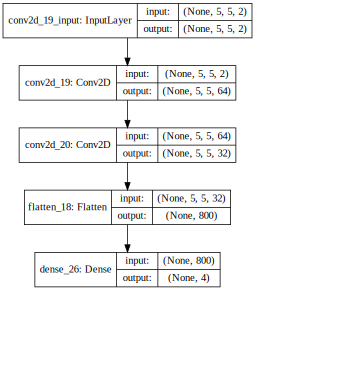

In [53]:
# Display the model layers (again):
SVG(model_to_dot(agent.model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

***
***
__Question 9__ Test both algorithms and compare their performances. Which issue(s) do you observe? Observe also different behaviors by changing the temperature.

In [55]:
env = Environment(grid_size=size, max_time=T,temperature=0.3)
agent_cnn = DQN_CNN(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
agent_cnn.load(name_weights='cnn_trainmodel.h5',name_model='cnn_trainmodel.json')

agent_fc = DQN_FC(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
agent_cnn.load(name_weights='fc_trainmodel.h5',name_model='fc_trainmodel.json')
print('Test of the CNN')
test(agent_cnn,env,epochs_test,prefix='cnn_test')
print('Test of the FC')
test(agent_fc,env,epochs_test,prefix='fc_test')

Test of the CNN
Win/lose count 0/1.0. Average score (-1.0)
Win/lose count 2.0/2.0. Average score (-0.5)
Win/lose count 0.5/0. Average score (-0.16666666666666666)
Win/lose count 0.5/0. Average score (0.0)
Win/lose count 1.0/1.0. Average score (0.0)
Win/lose count 2.5/1.0. Average score (0.25)
Win/lose count 3.0/1.0. Average score (0.5)
Win/lose count 1.0/1.0. Average score (0.4375)
Win/lose count 0.5/2.0. Average score (0.2222222222222222)
Win/lose count 0.5/3.0. Average score (-0.05)
Win/lose count 3.0/3.0. Average score (-0.045454545454545456)
Win/lose count 1.5/2.0. Average score (-0.08333333333333333)
Win/lose count 1.0/0. Average score (0.0)
Win/lose count 0.5/5.0. Average score (-0.32142857142857145)
Win/lose count 0/3.0. Average score (-0.5)
Win/lose count 1.0/1.0. Average score (-0.46875)
Win/lose count 3.0/0. Average score (-0.2647058823529412)
Win/lose count 0.5/2.0. Average score (-0.3333333333333333)
Win/lose count 2.5/0. Average score (-0.18421052631578946)
Win/lose count 

In [56]:
HTML(display_videos('cnn_test10.mp4'))

In [57]:
HTML(display_videos('fc_test10.mp4'))

One of the behaviors we can observe is the agent getting stuck (when testing with the greedy policy $\pi^*(s) = \arg\max_a q_\theta(s,a)$) and cycling between a set of states.

***

The algorithm tends to not explore the map which can be an issue. We propose two ideas in order to encourage exploration:
1. Incorporating a decreasing $\epsilon$-greedy exploration. You can use the method ```set_epsilon```
2. Append via the environment a new state that describes if a cell has been visited or not

***
__Question 10__ Design a new ```train_explore``` function and environment class ```EnvironmentExploring``` to tackle the issue of exploration.



In [ ]:
def train_explore(agent,env,epoch,prefix=''):
    pass
        
class EnvironmentExploring(object):
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        pass
    
## use those samples of code:
#In train explore:
state, reward, game_over = env.act(action, train=True)

## In Environment exploring:
# You will have to change n_state to 3 because you will use one more layer!
reward = 0
if train:
    reward = -self.malus_position[self.x, self.y]
self.malus_position[self.x, self.y] = 0.1

reward = reward + self.board[self.x, self.y]
# 3 "feature" states instead of 2
state = np.concatenate((self.malus_position.reshape(self.grid_size, self.grid_size,1),
                                self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)

In [ ]:
# Training
env = EnvironmentExploring(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_CNN(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32,n_state=3)
train_explore(agent, env, epochs_train, prefix='cnn_train_explore')
HTML(display_videos('cnn_train_explore10.mp4'))

In [ ]:
# Evaluation
test(agent,env,epochs_test,prefix='cnn_test_explore')
HTML(display_videos('cnn_test_explore10.mp4'))

***
***
__BONUS question__ Use the expert DQN from the previous question to generate some winning games. Train a model that mimicks its behavior. Compare the performances.

***